# III. Prediction of GHGEmissions for Project 3 ML (Seattle Building Energy Consumption)

## Contents
    
1) <a href='#Sec.1'>Preparing the Data for the Prediction of GHGEmissions</a>
    1) <a href='#Sec.1.1'>Transforming the target</a>
    1) <a href='#Sec.1.2'>Selecting all the columns that will be used for the iteration and train_test_split the data</a>
    1) <a href='#Sec.1.3'>Creating all possible combinations of columns in set 1 and set 2</a>
1) <a href='#Sec.2'>Performing the ML Models Test</a>
    1) <a href='#Sec.2.1'>Iteration and testing</a>
    1) <a href='#Sec.2.2'>Analysis of the tested models</a>
        1) <a href='Sec.2.2.1'> Best test</a>
        1) <a href='Sec.2.2.2'> Score analysis</a>
        1) <a href='Sec.2.2.3'> Training time analysis</a>
        1) <a href='Sec.2.2.4'> Errors and score of each model</a>
    1) <a href='#Sec.2.3'>Selecting the best model and best parameters to perform the final tests on few additional columns</a>
        1) <a href='#Sec.2.3.1'>Dummy models on the target</a>
        1) <a href='#Sec.2.3.2'>Perform tests on few additional columns using the best model</a>
            1) <a href='#Sec.2.3.2.1'>Predicted versus real value of the target</a>
            1) <a href='#Sec.2.3.2.2'>Features importance</a>
        1) <a href='#Sec.2.3.3'>Perform a final test on 'ENERGYSTARScore' column</a>
            1) <a href='#Sec.2.3.3.1'>Predicted versus real value of the target</a>
            1) <a href='#Sec.2.3.3.2'>Features importance</a>
    1) <a href='#Sec.2.4'>Summary</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import missingno as msno
import os

from stdnum.ean import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import *
from sklearn import dummy
from sklearn.kernel_ridge import KernelRidge

from itertools import combinations

from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

import statsmodels.api

import time

sns.set()

In [2]:
# To display all columns
pd.set_option('display.max_columns', None)

# Read the dataset
building_df_clean = pd.read_csv('building_df_cleaned.csv',
                                sep='\t', low_memory=False)
print('The size of the table is', building_df_clean.shape[0],
      'rows, and', building_df_clean.shape[1], 'columns.')

The size of the table is 1341 rows, and 41 columns.


## <font id='Sec.1'> 1. Preparing the Data for the Prediction of TotalGHGEmissions

The test will consiste of three phases:

**Phase 1:**
We will first select the columns that will be used for iteration. Then we will divide them into two sets, one without and one with the feature engineering. Then we will iterate on each set that will be used for this phase models testing.
- For the Y target, we will perform log transformation on GHGEmissions and test the models with and without log transformation.
- For the X features, we will use 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'PrimaryPropertyType', 'ZipCode', 'MainEnergySource', 'EnergySourceCount', 'column.endswith('_GFAratio')' and will ierate on them according to two set of cases:

    - Set_1:
        - Iteration on 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'PrimaryPropertyType', 'ZipCode', 'MainEnergySource', 'EnergySourceCount'

    - Set_2:
        - Iteration on 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'column.endswith('_GFAratio')', 'ZipCode', 'MainEnergySource', 'EnergySourceCount'

**Phase 2:**
After selecting the best columns from phase 1, best model and parameters, we will add these columns for testing:
- 'NumberofFloors', 'BuildingType', 'BuildingDecade', and 'BuildingAge'

**Phase 3:**
After selecting the final list of columns from phase 1 and 2, we do the final test on 'ENERGYSTARSCORE'

### <font id='Sec.1.1'> A. Transforming the target
Log transforming the target. The target with and without log transformation will be used for the model testing.

Skewness value for TotalGHGEmissions before and after log transformation equal to 2.3492480871663495 and -0.2423979687514646 respectively.


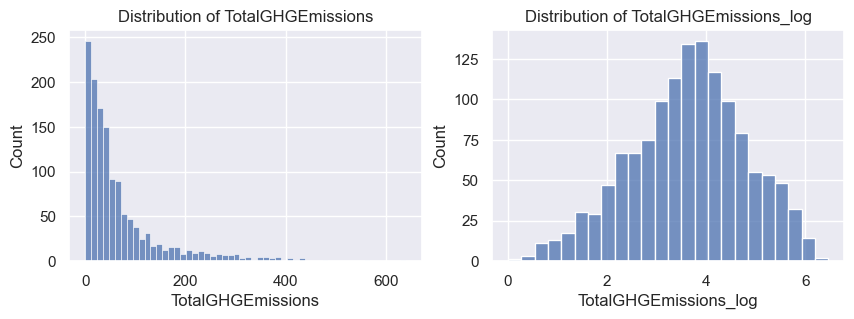

In [3]:
building_df_clean['TotalGHGEmissions_log'] = np.log(1 + building_df_clean['TotalGHGEmissions'])
print ('Skewness value for TotalGHGEmissions before and after log transformation equal to {} and {} respectively.'
       .format(st.skew(building_df_clean['TotalGHGEmissions']),
               st.skew(building_df_clean['TotalGHGEmissions_log'])))

columns_toplot = ['TotalGHGEmissions', 'TotalGHGEmissions_log']
n_sub = len(columns_toplot)
n_col = 2
fig, axes = plt.subplots(int(round((0.49+n_sub/n_col), 0)),
                         n_col, figsize=(10, int(1.5*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    sns.histplot(data=building_df_clean[columns_toplot[i]], ax=ax)
    ax.set_title('Distribution of {}'.format(columns_toplot[i]))
    i += 1
plt.show()

### <font id='Sec.1.2'> B. Selecting all the columns that will be used for the iteration and train_test_split the data

In [4]:
# Changing some columns type to object
building_df_clean[['ZipCode', 'MainEnergySource',
                   'EnergySourceCount', 'BuildingDecade']] = building_df_clean[['ZipCode', 'MainEnergySource',
                                                                                'EnergySourceCount', 'BuildingDecade']].astype(object)

# Creating a database with columns are not null
columns_list_target = ['TotalGHGEmissions', 'TotalGHGEmissions_log']
columns_list_data_1 = ['PropertyGFATotal', 'PropertyGFABuilding(s)',
                       'LargestPropertyUseTypeGFA', 'PrimaryPropertyType',
                       'ZipCode', 'MainEnergySource', 'EnergySourceCount',
                       'NumberofFloors', 'BuildingType', 'BuildingDecade', 'BuildingAge']
columns_list_data_2 = [column for column in building_df_clean.columns if column.endswith('_GFAratio')]
columns_list_data = columns_list_data_1 + columns_list_data_2
columns_list = columns_list_data + columns_list_target

data = building_df_clean[(building_df_clean[columns_list].notna()).all(axis=1)].reset_index(drop=True)
data = data[columns_list]

# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(data[columns_list_data],
                                                data[columns_list_target],
                                                train_size=0.8, random_state=42)

# To keep the original index of the train and test data
train_index = xtrain.index
test_index = xtest.index

# Resetting index before the preprocessing
xtrain = xtrain.reset_index(drop=True)
xtest = xtest.reset_index(drop=True)
ytrain = ytrain.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

### <font id='Sec.1.3'> C. Creating all possible combinations of columns in set 1 and set 2
- Set_1 combinations dictionary:

In [5]:
# Creating all possible iteration of columns in set 1
set_1_columns_fix = ['PropertyGFATotal' , 'PrimaryPropertyType']
set_1_columns_to_iterate_on = ['PropertyGFABuilding(s)' , 'LargestPropertyUseTypeGFA' ,
                               'ZipCode', 'MainEnergySource', 'EnergySourceCount']

set_1_columns_iter_dict = {}
i = 0
for j in np.arange(0, len(set_1_columns_to_iterate_on)+1):
    for k in list(combinations(set_1_columns_to_iterate_on, j)):
        set_1_columns_iter_dict['set_1_col_iter_{0}'.format(i)] = set_1_columns_fix + list(k)
        i += 1

- Set_2 combinations dictionary:

In [6]:
# Creating all possible iteration of columns in set 2
set_2_columns_fix = ['PropertyGFATotal'] + [column for column in building_df_clean.columns if column.endswith('_GFAratio')]
set_2_columns_to_iterate_on = ['PropertyGFABuilding(s)', 'ZipCode',
                               'MainEnergySource', 'EnergySourceCount']

set_2_columns_iter_dict = {}
i = 0
for j in np.arange(0, len(set_2_columns_to_iterate_on)+1):
    for k in list(combinations(set_2_columns_to_iterate_on, j)):
        set_2_columns_iter_dict['set_2_col_iter_{0}'.format(i)] = set_2_columns_fix + list(k)
        i += 1

- Merging the two dictionaries:

In [7]:
set_1_columns_iter_dict.update(set_2_columns_iter_dict)

Standardization before train_test_split can lead to data leakage. Thus, after train_test_split, we fit_transform the xtrain and transform the xtest for the standardization purpose. However, this also can lead to data leakage since we are using GridSearchCV on the xtrain data. To prevent this, We will assemble both the standardization and ML models in a pipeline then we use the pipeline as the estimator for GridSearchCV.

**Procedure:**
- Standardization will consiste of log scaling the numerical columns, and encode the categorical columns.
- First, we will pipeline the standardization and the ML models in order to use it on **xtrain** as estimator for the GridSearchCV.
- Second, we will record the best parameter for the ML model.
- Finally, we will pipeline the standardization and the ML models using the best parameter in order to fit the xtrain and predict the target from the xtest in order to be compared to ytest. 

## <font id='Sec.2'> 2) Performing the ML Models Test

In [8]:
score = ('neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2')

# Function to calculate the Root Mean Square Percentage Error
# source : https://stackoverflow.com/questions/53165807/how-to-calculate-rmspe-in-python-using-numpy
def RMPSE(y_true, y_pred):
    # compute Root Mean Square Percentage Error between two arrays.
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss


# Function that pick the best rank between 'neg_mean_absolute_error', 'neg_root_mean_squared_error', and 'r2' according to the fastest training time between them
def refit_strategy(cv_results):
    cv_results_ = pd.DataFrame(cv_results)

    # selecting the param best score using the different scoring method
    best_score_cv_results = cv_results_[(cv_results_['rank_test_neg_mean_absolute_error'] == 1)
                                        | (cv_results_['rank_test_neg_root_mean_squared_error'] == 1)
                                        | (cv_results_['rank_test_r2'] == 1)]

    # selecting the fastest mean_fit_time
    best_score_time_cv_results_index = best_score_cv_results['mean_fit_time'].idxmin()
    columns_list = ['mean_fit_time', 'std_fit_time', 'params',
                    'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
                    'mean_test_neg_root_mean_squared_error', 'std_test_neg_root_mean_squared_error',
                    'mean_test_r2', 'std_test_r2',]

    return(best_score_time_cv_results_index)

# Function that tranform grid.cv_results_ into dataframe
def resultize(grid):
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('rank_test_r2')

    return res

# Function to find optimal param with grid search
def grid_search(model, param_grid, cv, scoring, refit, xtrain, ytrain):

    # we initiate the GridSearchCV
    grid = GridSearchCV(model, param_grid, cv=cv,
                        scoring=scoring, verbose=1,
                        return_train_score=True,
                        refit=refit, n_jobs=-1)
    start = time.time()

    # we fit the GridSearchCV
    grid.fit(xtrain, ytrain)
    stop = time.time()
    return grid.best_params_


# Apply the best param obtained from the grid on the model
def estimator_model(estimator, xtrain, ytrain, xtest, ytest):
    start = time.time()

    # We fit eh model
    estimator.fit(xtrain, ytrain)
    stop = time.time()

    # we test the train and test accuracy to check overfitting
    train_accuracy = estimator.score(xtrain, ytrain)
    test_accuracy = estimator.score(xtest, ytest)

    # we calcultae ypred to be compared with ytest
    ypred = estimator.predict(xtest)

    # we calcultate the errors and score of the model
    error_MAE = mean_absolute_error(ytest, ypred)
    error_MAPE = mean_absolute_percentage_error(ytest, ypred)
    error_RMSE = np.sqrt(mean_squared_error(ytest, ypred))
    error_RMPSE = RMPSE(ytest, ypred)
    score_r2 = r2_score(ytest, ypred)
    training_time = stop - start

    return train_accuracy, test_accuracy, ypred, error_MAE, error_MAPE, error_RMSE, error_RMPSE, score_r2, training_time

### <font id='Sec.2.1'> A. Iteration and testing

Procedure:
- 1st, we loop on the two targets (with and without log transformation)
- 2nd, we loop on all selected columns combinations
- 3rd, we loop on the scaler for the numerical columns in xtrain and xtest (MinMax, Standard, Robust, and PowerTransformer)
- 4th, preprocessor, we pipeline together the scaler for the numerical columns and the OneHotEncoder for the categorical columns
- 5th, we loop on the model and the its grid parameters
- 6th, we pipeline the preprocessor with the model and perform GridSearchCV in order to find the best parmaters for the model
- 7th, we apply the best parameters found by GridSearchCV on the model using xtrain and ytrain and test it on xtest and ytest
- 8th, we record into dataset the columns tested, target, model, best parameters, and scaler, as well as the errors, score, and training time obtained comparing ypred with ytest
- Finally we select the best score from all the iterations and extract the informations.

In [9]:
# We create dataframe to store the error and score values of the models
ML_results_df = pd.DataFrame(columns = ['DataSetName', 'DataSetCols', 'Target',
                                        'Scaler', 'Model', 'BestParams'])

# Loop on the target with and without log transformation
for target_col in ['TotalGHGEmissions', 'TotalGHGEmissions_log']:
    # loop on the columns set
    for set_columns_list in set_1_columns_iter_dict:
        # we select the colomns in xtrain and ytrain
        xtrain_select = xtrain[set_1_columns_iter_dict[set_columns_list]]
        xtest_select = xtest[set_1_columns_iter_dict[set_columns_list]]
        ytrain_select = ytrain[target_col]
        ytest_select = ytest[target_col]

        # we divide the colomn into numerical colomn and categorical columns
        num_features = [col for col in xtrain_select.columns if not ((xtrain_select[col].dtype == 'object')
                                                                     | (col.endswith('_GFAratio')))]
        cat_features = [col for col in xtrain_select.columns if xtrain_select[col].dtype == 'object']

        #loop on the scaler
        for scaler in [('MinMaxScaler', MinMaxScaler()), ('StandardScaler', StandardScaler()),
                       ('RobustScaler', RobustScaler()), ('PowerTransformer', PowerTransformer())]:

            # maps the transformers to the relevant columns
            num_pipe = make_pipeline(scaler[1])
            cat_pipe = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown='ignore',
                                                   dtype=np.int32))
            preprocessor = ColumnTransformer(transformers=[('scale', num_pipe, num_features),
                                                           ('oh_encode', cat_pipe, cat_features)],
                                             remainder='passthrough', verbose_feature_names_out=False)
            preprocessor.set_output(transform='pandas')

            # loop on the ML models
            for model_name, grid_params in [[('LinearRegression', LinearRegression()), {'LinearRegression__fit_intercept':(True, False)}],
                                            [('ElasticNet', ElasticNet()), {'ElasticNet__alpha':np.logspace(-3, 0, 4),
                                                                            'ElasticNet__l1_ratio':np.around(np.arange(0., 1.01, 0.1),2),
                                                                            'ElasticNet__tol':np.logspace(-4, 0, 5)}],
                                            [('KernelRidge', KernelRidge()), {'KernelRidge__kernel':['poly', 'rbf'],
                                                                              'KernelRidge__alpha':np.logspace(-3, 1, 5),
                                                                              'KernelRidge__gamma':np.logspace(-3, 0, 4)}],
                                            [('KNeighborsRegressor', KNeighborsRegressor()), {'KNeighborsRegressor__n_neighbors':np.arange(2, 21, 1),
                                                                                              'KNeighborsRegressor__weights':('uniform', 'distance')}],
                                            [('RandomForestRegressor', RandomForestRegressor()), {'RandomForestRegressor__n_estimators':[10,50,100,200,500],
                                                                                                  'RandomForestRegressor__min_samples_split':np.arange(2, 11, 2)}],
                                            [('XGBRegressor', XGBRegressor()), {'XGBRegressor__n_estimators':[25, 50, 75, 100],
                                                                                'XGBRegressor__max_depth':[2, 4, 6]}]
                                           ]:
                # find optimal param with grid search
                estimator = Pipeline(steps=[('preprocessor', preprocessor), model_name])
            
                best_params = grid_search(estimator, grid_params, 5, score,
                                          refit_strategy, xtrain_select, ytrain_select)

                # apply the best param obtained from the grid on the model
                estimator = Pipeline(steps=[('preprocessor', preprocessor), model_name])
                estimator.set_params(**best_params)
                train_accuracy, test_accuracy, ypred_select, error_MAE, error_MAPE, error_RMSE, error_RMPSE, score_r2, training_time = estimator_model(estimator, xtrain_select, ytrain_select, xtest_select, ytest_select)

                # storing the regressor results in df
                regressor_results_df = pd.DataFrame()
                df = pd.DataFrame(np.array([train_accuracy, test_accuracy, error_MAE, error_MAPE,
                                            error_RMSE, error_RMPSE, score_r2, training_time])).T
                regressor_results_df[['train_accuracy', 'test_accuracy',
                                      'error_MAE', 'error_MAPE',
                                      'error_RMSE', 'error_RMPSE',
                                      'score_r2', 'training_time (s)']] = df
                regressor_results_df['BestParams'] = str(best_params)
                regressor_results_df['DataSetName'] = set_columns_list
                regressor_results_df['DataSetCols'] = str(set_1_columns_iter_dict[set_columns_list])
                regressor_results_df['Target'] = target_col
                regressor_results_df['Model'] = model_name[0]
                regressor_results_df['Scaler'] = scaler[0]
            
                ML_results_df = pd.concat([ML_results_df, regressor_results_df], ignore_index=True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 fol

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 f

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 f

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 fol

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 f

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits


C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.023e+02, tolerance: 1.437e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.023e+02, tolerance: 1.437e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 fol

C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+02, tolerance: 1.437e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+02, tolerance: 1.437e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 fol

C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+02, tolerance: 1.437e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+02, tolerance: 1.437e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e+02, tolerance: 1.437e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e+02, tolerance: 1.437e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e+02, tolerance: 1.437e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e+02, tolerance: 1.437e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 fol

C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+02, tolerance: 1.437e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+02, tolerance: 1.437e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 fol

C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e+02, tolerance: 1.437e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e+02, tolerance: 1.437e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e+02, tolerance: 1.437e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DJANGO\.conda\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e+02, tolerance: 1.437e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 f

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 38 candidates, totalling 190 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 fol

### <font id='Sec.2.2'> B. Analysis of the tested models

In [10]:
ML_results_df.sort_values('score_r2', ascending=False).head()

DataSetName                                        DataSetCols  \
2252  set_2_col_iter_13  ['PropertyGFATotal', 'Bank Branch_GFAratio', '...   
1676  set_1_col_iter_21  ['PropertyGFATotal', 'PrimaryPropertyType', 'P...   
1844  set_1_col_iter_28  ['PropertyGFATotal', 'PrimaryPropertyType', 'P...   
1892  set_1_col_iter_30  ['PropertyGFATotal', 'PrimaryPropertyType', 'L...   
2180  set_2_col_iter_10  ['PropertyGFATotal', 'Bank Branch_GFAratio', '...   

                     Target            Scaler        Model  \
2252  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
1676  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
1844  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
1892  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
2180  TotalGHGEmissions_log  PowerTransformer  KernelRidge   

                                             BestParams  train_accuracy  \
2252  {'KernelRidge__alpha': 1.0, 'KernelRidge__gamm...        0.747351   
1676  {'KernelRidge__alpha': 0.01, 'KernelRidge__gam...        0.738232   
1844  {'KernelRidge__alpha': 0.01, 'KernelRidge__gam...        0.742933   
1892  {'KernelRidge__alpha': 0.1, 'KernelRidge__gamm...        0.734728   
2180  {'KernelRidge__alpha': 1.0, 'KernelRidge__gamm...        0.741703   

      test_accuracy  error_MAE  error_MAPE  error_RMSE  error_RMPSE  score_r2  \
2252       0.717530   0.500687    0.213570    0.638123     0.477518  0.717530   
1676       0.715892   0.491972    0.209953    0.639970     0.470055  0.715892   
1844       0.715279   0.493174    0.210273    0.640660     0.469413  0.715279   
1892       0.714465   0.499882    0.212825    0.641575     0.472820  0.714465   
2180       0.714441   0.505280    0.213464    0.641603     0.472621  0.714441   

      training_time (s)  
2252           0.070618  
1676           0.064000  
1844           0.064679  
1892           0.085652  
2180           0.077968

#### <font id='Sec.2.2.1'> a) Best test

In [11]:
# Selecting the the best model informations
best_model_index = 1676
Data_Set_Name = ML_results_df.loc[best_model_index, 'DataSetName']

ML_results_df.iloc[best_model_index]

DataSetName                                          set_1_col_iter_21
DataSetCols          ['PropertyGFATotal', 'PrimaryPropertyType', 'P...
Target                                           TotalGHGEmissions_log
Scaler                                                PowerTransformer
Model                                                      KernelRidge
BestParams           {'KernelRidge__alpha': 0.01, 'KernelRidge__gam...
train_accuracy                                                0.738232
test_accuracy                                                 0.715892
error_MAE                                                     0.491972
error_MAPE                                                    0.209953
error_RMSE                                                     0.63997
error_RMPSE                                                   0.470055
score_r2                                                      0.715892
training_time (s)                                                0.064
Name: 

According to the overfitting test, the train and test accuracy are very close which indicate that we have very low overfitting problem.

In [12]:
best_model_name = ML_results_df.loc[best_model_index, 'Model']
best_grid_params = ML_results_df.loc[best_model_index, 'BestParams']
print('The best parameters from the model', best_grid_params)
best_scaler = ML_results_df.loc[best_model_index, 'Scaler']

# Preparing xtrain and ytrain
xtrain_select_columns = eval(ML_results_df.loc[best_model_index, 'DataSetCols'])
ytrain_select_column = ML_results_df.loc[best_model_index, 'Target']
xtrain_select = xtrain[xtrain_select_columns]
xtest_select = xtest[xtrain_select_columns]
ytrain_select = ytrain[ytrain_select_column]
ytest_select = ytest[ytrain_select_column]
print('')
print('Columns list used by the model for the prediction:', xtrain_select_columns)

The best parameter from the model {'KernelRidge__alpha': 0.01, 'KernelRidge__gamma': 0.01, 'KernelRidge__kernel': 'poly'}

Columns list used by the model for the prediction: ['PropertyGFATotal', 'PrimaryPropertyType', 'PropertyGFABuilding(s)', 'MainEnergySource', 'EnergySourceCount']


#### <font id='Sec.2.2.2'> b) Score analysis
- Effect of the scaler for the numerical columns in xtrain and xtest:

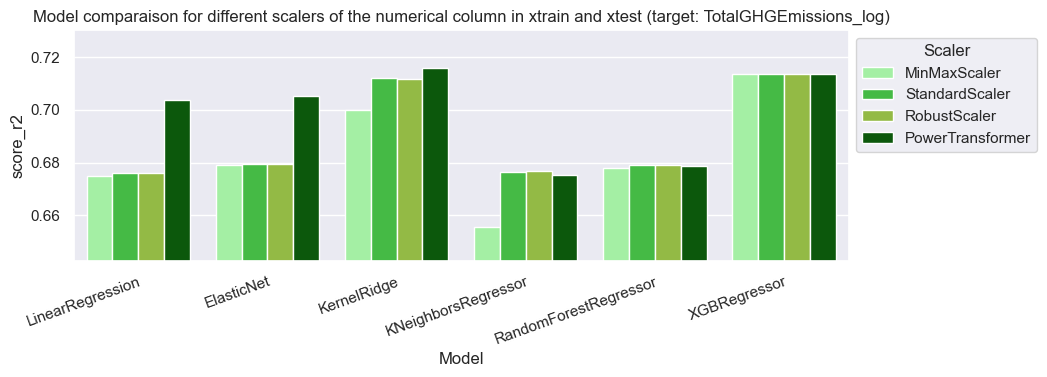

In [13]:
Data_Set_Name = ML_results_df.loc[best_model_index, 'DataSetName']
ytrain_select_column = ML_results_df.loc[best_model_index, 'Target']

condition = ((ML_results_df['DataSetName'] == Data_Set_Name)
             & (ML_results_df['Target'] == ytrain_select_column))

plt.figure(figsize=(10, 3))
ax = sns.barplot(x=ML_results_df[condition]['Model'],
                 y=ML_results_df[condition]['score_r2'],
                 hue=ML_results_df['Scaler'],
                 palette=['palegreen', 'limegreen',
                          'yellowgreen', 'darkgreen'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Model comparaison for different scalers of the numerical column in xtrain and xtest (target: {})'
          .format(ytrain_select_column))
plt.xticks(ha='right', rotation=20, rotation_mode='anchor')
plt.ylim([ML_results_df[condition]['score_r2'].min()*0.98,
          ML_results_df[condition]['score_r2'].max()*1.02])
plt.show()

PowerTransformer giving the best score for most of the models comparing to StandardScaler and MinMaxScaler.
For XGBoost, all 4 scalers give the same score.
For KNN, MinMaxScaler give lower score comparing to the other scaler.

For the best model **KernelRidge**, we got the **highest score** for **PowerTransformer**.

- Effect of log transforming the target:

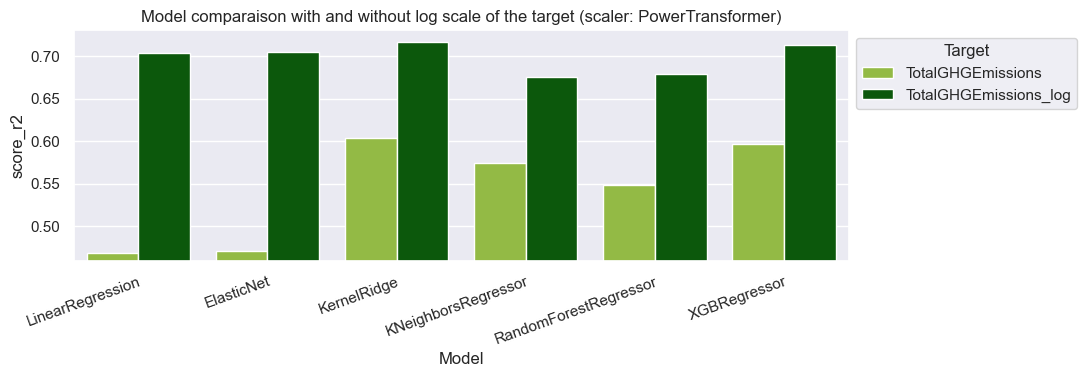

In [14]:
best_scaler = ML_results_df.loc[best_model_index, 'Scaler']

condition = ((ML_results_df['DataSetName'] == Data_Set_Name)
             & (ML_results_df['Scaler'] == best_scaler))

plt.figure(figsize=(10, 3))
ax = sns.barplot(x=ML_results_df[condition]['Model'],
                 y=ML_results_df[condition]['score_r2'],
                 hue=ML_results_df['Target'],
                 palette=['yellowgreen', 'darkgreen'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Model comparaison with and without log scale of the target (scaler: {})'
          .format(best_scaler))
plt.xticks(ha='right', rotation=20, rotation_mode='anchor')
plt.ylim([ML_results_df[condition]['score_r2'].min()*0.98,
          ML_results_df[condition]['score_r2'].max()*1.02])
plt.show()

Log scaling giving better score for all models with KernelRidge as the best with a score above 0.7.

#### <font id='Sec.2.2.3'> c) Training time analysis

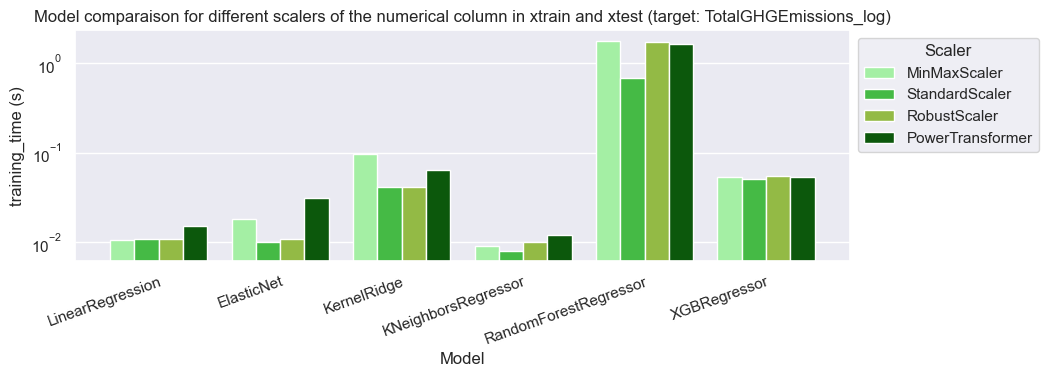

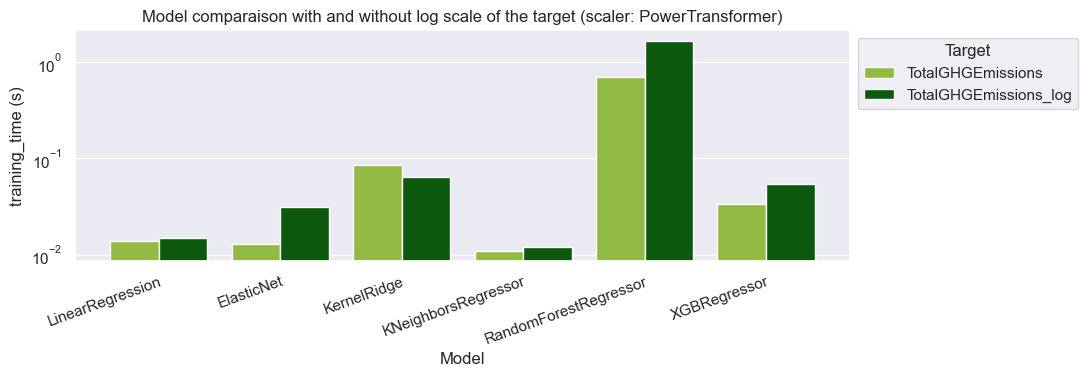

In [15]:
ytrain_select_column = ML_results_df.loc[best_model_index,'Target']

condition = ((ML_results_df['DataSetName'] == Data_Set_Name)
             & (ML_results_df['Target'] == ytrain_select_column))

plt.figure(figsize=(10, 3))
ax = sns.barplot(x=ML_results_df[condition]['Model'],
                 y=ML_results_df[condition]['training_time (s)'],
                 hue=ML_results_df['Scaler'],
                 palette=['palegreen', 'limegreen',
                          'yellowgreen', 'darkgreen'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Model comparaison for different scalers of the numerical column in xtrain and xtest (target: {})'
          .format(ytrain_select_column))
plt.xticks(ha='right', rotation=20, rotation_mode='anchor')
plt.semilogy()
plt.show()

ytrain_select_column = ML_results_df.loc[best_model_index, 'Target']

condition = ((ML_results_df['DataSetName'] == Data_Set_Name)
             & (ML_results_df['Scaler'] == best_scaler))

plt.figure(figsize=(10, 3))
ax = sns.barplot(x=ML_results_df[condition]['Model'],
                 y=ML_results_df[condition]['training_time (s)'],
                 hue=ML_results_df['Target'],
                 palette=['yellowgreen', 'darkgreen'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Model comparaison with and without log scale of the target (scaler: {})'
          .format(best_scaler))
plt.xticks(ha='right', rotation=20, rotation_mode='anchor')
plt.semilogy()
plt.show()

LinearRegression has the fastest training time followed by KNN and ElasticNet while RandomForest is at lest one order of magnitude slower than the other models.

The scaler effect on the training time depend largely on the models tested and no apparent effect of the log transformation of the target on the training time.

#### <font id='Sec.2.2.4'> d) Errors and score of each model

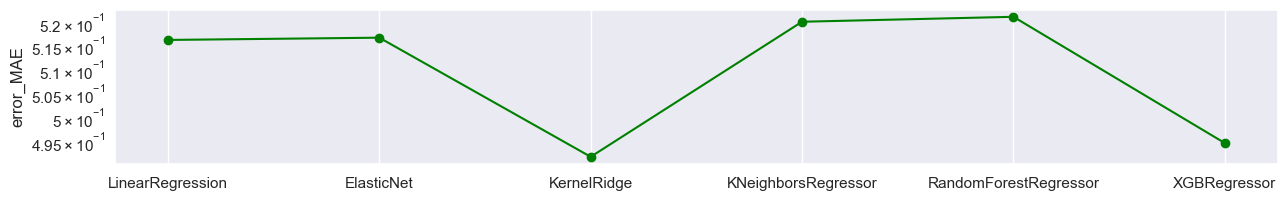

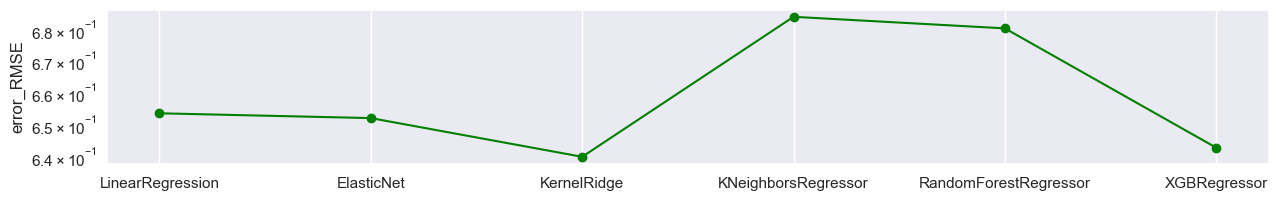

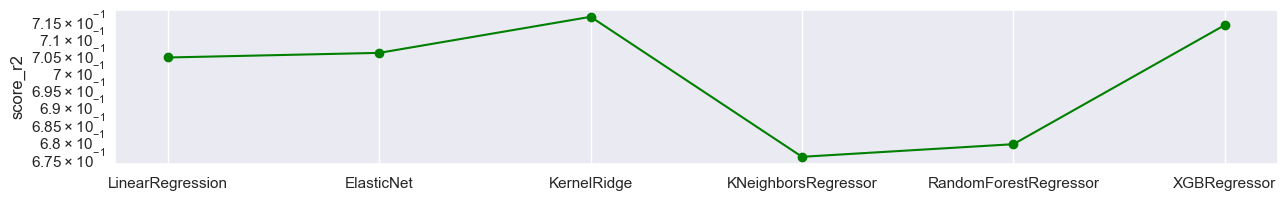

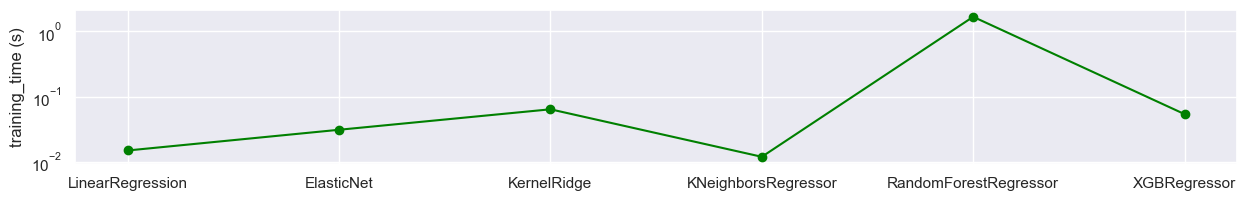

In [16]:
condition = ((ML_results_df['DataSetName'] == Data_Set_Name)
             & (ML_results_df['Target'] == ytrain_select_column)
             & (ML_results_df['Scaler'] == best_scaler))

plt.figure(figsize=(15, 2))
plt.plot(ML_results_df[condition]['Model'].unique(),
         ML_results_df[condition]['error_MAE'],
         c='green', marker='o', markerfacecolor='green')
plt.ylabel('error_MAE')
plt.semilogy()
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(ML_results_df[condition]['Model'].unique(),
         ML_results_df[condition]['error_RMSE'],
         c='green', marker='o', markerfacecolor='green')
plt.ylabel('error_RMSE')
plt.semilogy()
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(ML_results_df[condition]['Model'].unique(),
         ML_results_df[condition]['score_r2'],
         c='green', marker='o', markerfacecolor='green')
plt.ylabel('score_r2')
plt.semilogy()
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(ML_results_df[condition]['Model'].unique(),
         ML_results_df[condition]['training_time (s)'],
         c='green', marker='o', markerfacecolor='green')
plt.ylabel('training_time (s)')
plt.semilogy()
plt.show()

Between all 6 models, KernelRidge has the lowest errors and the best score.

### <font id='Sec.2.3'> C. Selecting the best model and best parameters to perform the final tests on few additional columns

#### <font id='Sec.2.3.1'> a) Dummy models on the target
- Random value generation between min and max of the target
- Dummy regressor based on mean value of the target
- Dummy regressor based on median value of the target

In [17]:
# Random distribution model, value betwen min and max of the target
start = time.time()
ypred_select = np.random.randint(np.min(ytrain_select), np.max(ytrain_select), ytest_select.shape)
stop = time.time()
print('MAE =', mean_absolute_error(ytest_select, ypred_select))
print('MAPE =', mean_absolute_percentage_error(ytest_select, ypred_select))
print('RMSE =', np.sqrt(mean_squared_error(ytest_select, ypred_select)))
print('RMPSE =', RMPSE(ytest_select, ypred_select))
print('Score R2 =', r2_score(ytest_select, ypred_select))
print(f'Training time = {stop - start} s')

MAE = 1.8657224781950998
MAPE = 0.6500516181381574
RMSE = 2.2752076701673793
RMPSE = 1.106182556729691
Score R2 = -2.590919107873679
Training time = 0.0 s


In [18]:
# Mean distribution model
dum = dummy.DummyRegressor(strategy='mean')
start = time.time()
dum.fit(xtrain_select, ytrain_select)
stop = time.time()
ypred_select = dum.predict(xtest_select)
print('MAE =', mean_absolute_error(ytest_select, ypred_select))
print('MAPE =', mean_absolute_percentage_error(ytest_select, ypred_select))
print('RMSE =', np.sqrt(mean_squared_error(ytest_select, ypred_select)))
print('RMPSE =', RMPSE(ytest_select, ypred_select))
print('Score R2 =', r2_score(ytest_select, ypred_select))
print(f'Training time = {stop - start} s')

MAE = 0.9451607261781608
MAPE = 0.45540746437616253
RMSE = 1.2009640413558023
RMPSE = 1.0560742171204311
Score R2 = -0.0005148616078147761
Training time = 0.0 s


In [19]:
# Median distribution model
dum = dummy.DummyRegressor(strategy='median')
start = time.time()
dum.fit(xtrain_select, ytrain_select)
stop = time.time()
ypred_select = dum.predict(xtest_select)
print('MAE =', mean_absolute_error(ytest_select, ypred_select))
print('MAPE =', mean_absolute_percentage_error(ytest_select, ypred_select))
print('RMSE =', np.sqrt(mean_squared_error(ytest_select, ypred_select)))
print('RMPSE =', RMPSE(ytest_select, ypred_select))
print('Score R2 =', r2_score(ytest_select, ypred_select))
print(f'Training time = {stop - start} s')

MAE = 0.9454537064090044
MAPE = 0.462801161530454
RMSE = 1.2037101845475422
RMPSE = 1.0772202317832384
Score R2 = -0.005095678825056682
Training time = 0.013285636901855469 s


- Between the random generation, mean, and median dummy regressor, mean is the best with a r2 score of 0 and lower MAE and RMSE.

- By comparaison with the best model here, KernelRidge, we see lot lower MAE and RMSE and lot higher r2 score compared to dummy models.

#### <font id='Sec.2.3.2'> b) Perform tests on few additional columns using the best model

The additional columns that will be tested are: 'NumberofFloors', 'BuildingType', 'PropertyUseTypeCount', and 'BuildingDecade'

In [20]:
additional_cols = ['NumberofFloors', 'BuildingType',
                   'BuildingDecade', 'BuildingAge']

columns_iter_dict = {}
i = 0
for j in np.arange(0, len(additional_cols)+1):
    for k in list(combinations(additional_cols,j)):
        columns_iter_dict['col_iter_{0}'.format(i)] = xtrain_select_columns + list(k)
        i += 1

In [21]:
# We create dataframe to store the error and score values of the models
ML_results_df_additional = pd.DataFrame(columns=['DataSetName', 'DataSetCols', 'Target',
                                                 'Scaler', 'Model', 'BestParams'])

# Loop on the columns set
for set_columns_list in columns_iter_dict:
    # we select the colomns in xtrain and ytrain
    xtrain_select = xtrain[columns_iter_dict[set_columns_list]]
    xtest_select = xtest[columns_iter_dict[set_columns_list]]
    ytrain_select = ytrain[ytrain_select_column]
    ytest_select = ytest[ytrain_select_column]
    
    # we divide the colomn into numerical colomn and categorical columns
    num_features = [col for col in xtrain_select.columns if not ((xtrain_select[col].dtype == 'object')
                                                                 | (col.endswith('_GFAratio')))]
    cat_features = [col for col in xtrain_select.columns if xtrain_select[col].dtype == 'object']
    
    # maps the transformers to the relevant columns
    num_pipe = make_pipeline(eval(best_scaler)())
    cat_pipe = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown='ignore',
                                           dtype=np.int32))
    preprocessor = ColumnTransformer(transformers=[('scale', num_pipe, num_features),
                                                   ('oh_encode', cat_pipe, cat_features)],
                                     remainder='passthrough', verbose_feature_names_out=False)
    preprocessor.set_output(transform='pandas')

    # apply the best param obtained from the grid on the model
    estimator = Pipeline(steps=[('preprocessor', preprocessor),
                                (best_model_name, eval(best_model_name)())])
    estimator.set_params(**eval(best_grid_params))
    train_accuracy, test_accuracy, ypred_select, error_MAE, error_MAPE, error_RMSE, error_RMPSE, score_r2, training_time = estimator_model(estimator, xtrain_select, ytrain_select, xtest_select, ytest_select)
    
    # storing the regressor results in df
    regressor_results_df = pd.DataFrame()
    df = pd.DataFrame(np.array([train_accuracy, test_accuracy, error_MAE, error_MAPE,
                                error_RMSE, error_RMPSE, score_r2, training_time])).T
    regressor_results_df[['train_accuracy', 'test_accuracy',
                          'error_MAE', 'error_MAPE',
                          'error_RMSE', 'error_RMPSE',
                          'score_r2', 'training_time (s)']] = df
    regressor_results_df['BestParams'] = best_grid_params
    regressor_results_df['DataSetName'] = set_columns_list
    regressor_results_df['DataSetCols'] = str(columns_iter_dict[set_columns_list])
    regressor_results_df['Target'] = ytrain_select_column
    regressor_results_df['Model'] = best_model_name
    regressor_results_df['Scaler'] = best_scaler
    
    ML_results_df_additional = pd.concat([ML_results_df_additional, regressor_results_df], ignore_index=True)

In [22]:
ML_results_df_additional.sort_values('score_r2', ascending=False).head(7)[['DataSetName','Target','Scaler','Model','error_MAE','error_MAPE','error_RMSE','error_RMPSE','train_accuracy','score_r2','training_time (s)']]

DataSetName                 Target            Scaler        Model  \
9    col_iter_9  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
12  col_iter_12  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
4    col_iter_4  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
2    col_iter_2  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
7    col_iter_7  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
5    col_iter_5  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
0    col_iter_0  TotalGHGEmissions_log  PowerTransformer  KernelRidge   

    error_MAE  error_MAPE  error_RMSE  error_RMPSE  train_accuracy  score_r2  \
9    0.477040    0.203213    0.621510     0.453657        0.758690  0.732046   
12   0.482205    0.204419    0.627122     0.451583        0.768804  0.727185   
4    0.482812    0.204774    0.629638     0.456754        0.749864  0.724992   
2    0.486050    0.207891    0.632144     0.464934        0.747294  0.722799   
7    0.484008    0.205319    0.632658     0.455759        0.758771  0.722348   
5    0.489615    0.207528    0.635001     0.459046        0.756937  0.720287   
0    0.491972    0.209953    0.639970     0.470055        0.738232  0.715892   

    training_time (s)  
9            0.060520  
12           0.060585  
4            0.060409  
2            0.060530  
7            0.060624  
5            0.060341  
0            0.069042

In [23]:
# Selecting the the best model informations
best_model_index = ML_results_df_additional['score_r2'].idxmax()
print('Columns list used by the model for the prediction:',
      ML_results_df_additional.loc[best_model_index,'DataSetCols'])

Columns list used by the model for the prediction: ['PropertyGFATotal', 'PrimaryPropertyType', 'PropertyGFABuilding(s)', 'MainEnergySource', 'EnergySourceCount', 'BuildingType', 'BuildingAge']


Adding BuildingType and BuildingAge give better score and lower errors MAE and RMSE on the prediction. We will add those two columns to model prediction of GHGEmissions.

##### <font id='Sec.2.3.2.1'> i) Predicted versus real value of the target

In [24]:
# Preparing xtrain and ytrain
xtrain_select_columns = eval(ML_results_df_additional.loc[best_model_index, 'DataSetCols'])
ytrain_select_column = ML_results_df_additional.loc[best_model_index, 'Target']
xtrain_select = xtrain[xtrain_select_columns]
xtest_select = xtest[xtrain_select_columns]
ytrain_select = ytrain[ytrain_select_column]
ytest_select = ytest[ytrain_select_column]

In [25]:
# Separating numerical features for scaling from categorical feature for OneHotEncoding
num_features = [col for col in xtrain_select.columns if not ((xtrain_select[col].dtype == 'object')
                                                             | (col.endswith('_GFAratio')))]
cat_features = [col for col in xtrain_select.columns if xtrain_select[col].dtype == 'object']

In [26]:
# Maps the transformers to the relevant columns
num_pipe = make_pipeline(eval(best_scaler)())
cat_pipe = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown='ignore',
                                       dtype=np.int32))
preprocessor = ColumnTransformer(transformers=[('scale', num_pipe, num_features),
                                               ('oh_encode', cat_pipe, cat_features)],
                                 remainder='passthrough', verbose_feature_names_out=False)
preprocessor.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale',
                                 Pipeline(steps=[('powertransformer',
                                                  PowerTransformer())]),
                                 ['PropertyGFATotal', 'PropertyGFABuilding(s)',
                                  'BuildingAge']),
                                ('oh_encode',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(dtype=<class 'numpy.int32'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['PrimaryPropertyType', 'MainEnergySource',
                                  'EnergySourceCount', 'BuildingType'])],
                  verbose_feature_names_out=False)

In [27]:
# Apply the grid param on the best model
estimator = Pipeline(steps=[('preprocessor', preprocessor),
                            (best_model_name, eval(best_model_name)())])
estimator.set_params(**eval(best_grid_params))
train_accuracy, test_accuracy, ypred_select, error_MAE, error_MAPE, error_RMSE, error_RMPSE, score_r2, training_time = estimator_model(estimator, xtrain_select, ytrain_select, xtest_select, ytest_select)

print('Model {} with parameters {}.'.format(best_model_name, best_grid_params))
print('  X columns: {}.'.format(xtrain_select.columns))
print('  Y column: {}.'.format(ytrain_select_column))
print()
print('       MAE =', error_MAE)
print('       MAPE =', error_MAPE)
print('       RMSE =', error_RMSE)
print('       RMPSE =', error_RMPSE)
print('       Score R2 =', score_r2)
print('       Training time =', training_time)
print()
print('Overfitting check:')
print('       train_accuracy =', train_accuracy)
print('       test_accuracy =', test_accuracy)

Model KernelRidge with parameters {'KernelRidge__alpha': 0.01, 'KernelRidge__gamma': 0.01, 'KernelRidge__kernel': 'poly'}.
  X columns: Index(['PropertyGFATotal', 'PrimaryPropertyType', 'PropertyGFABuilding(s)',
       'MainEnergySource', 'EnergySourceCount', 'BuildingType', 'BuildingAge'],
      dtype='object').
  Y column: TotalGHGEmissions_log.

       MAE = 0.47704027307070757
       MAPE = 0.20321319130044843
       RMSE = 0.6215103393324876
       RMPSE = 0.4536570345460934
       Score R2 = 0.7320459957586416
       Training time = 0.05340313911437988

Overfitting check:
       train_accuracy = 0.758690340039509
       test_accuracy = 0.7320459957586416


The train and test accuracy are close to each other which means that we have low overfitting.

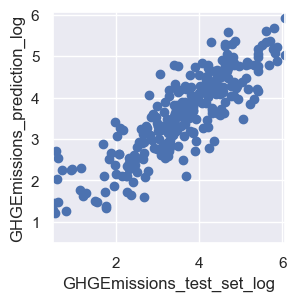

In [28]:
# Comparison between ypred and ytest
plt.figure(figsize=(3, 3))
plt.plot(ytest_select,ypred_select, 'o')
plt.xlabel('GHGEmissions_test_set_log')
plt.xlim([min([ytest_select.min(), ypred_select.min()]),
          max([ytest_select.max(), ypred_select.max()])])
plt.ylabel('GHGEmissions_prediction_log')
plt.ylim([min([ytest_select.min(), ypred_select.min()]),
          max([ytest_select.max(), ypred_select.max()])])
plt.show()

From the scatter plot, the prediction starts to become less accurate for GHGEmissions below 1 in lod scale which correspond to a value of 9 without low scale.

##### <font id='Sec.2.3.2.2'> ii) Features importance
- Computing the permutation importances on the test set

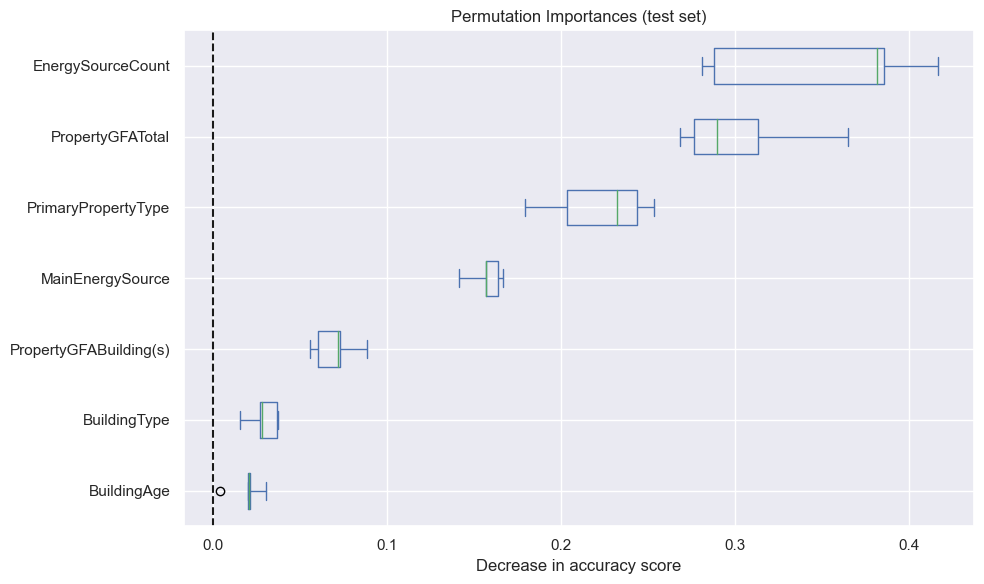

In [29]:
# fit the model
estimator.fit(xtrain_select, ytrain_select)
# perform permutation importance
result = permutation_importance(estimator, xtest_select, ytest_select,
                                n_repeats=5, random_state=42, n_jobs=-1)

# get importance
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                           columns=xtrain_select.columns[sorted_importances_idx])

ax = importances.plot.box(vert=False, whis=10, figsize=(10, 6))
ax.set_title('Permutation Importances (test set)')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()

- Computing the permutation importances on the training set:

To be compared with the test set to check for overfitting.

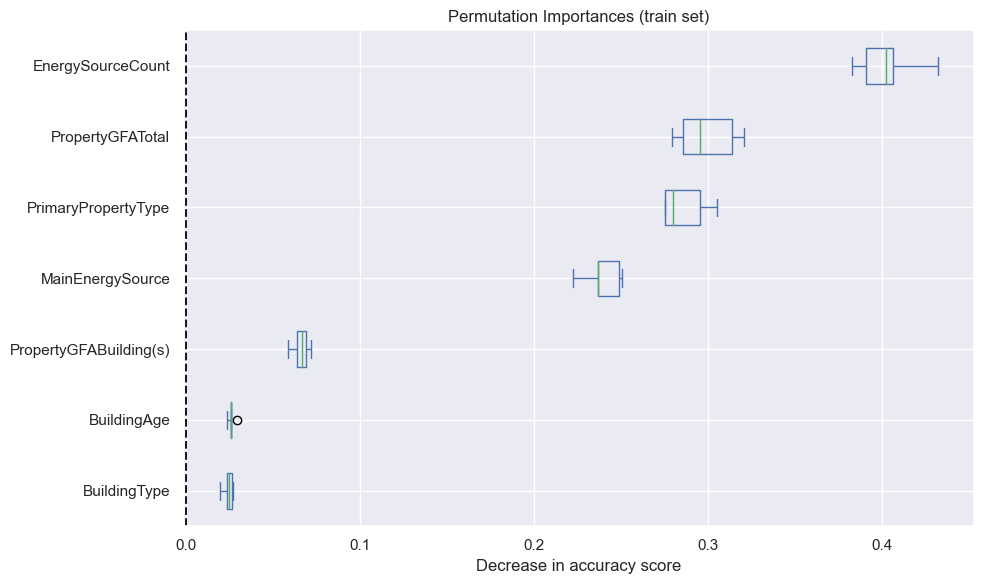

In [30]:
# perform permutation importance
result = permutation_importance(estimator, xtrain_select, ytrain_select,
                                n_repeats=5, random_state=42, n_jobs=-1)

# get importance
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                           columns=xtrain_select.columns[sorted_importances_idx])

ax = importances.plot.box(vert=False, whis=10, figsize=(10, 6))
ax.set_title('Permutation Importances (train set)')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()

- EnergySourceCount is the main feature for the model prediction of GHGEmissions.
- Top features importance are similar in both train and test set (low overfitting).
- As the training time is low, we will not select the most important features but we will keep using all the features for the model prediction.

#### <font id='Sec.2.3.3'> c) Perform a final test on 'ENERGYSTARScore' column
Since ENERGYSTARScore have missing values, we are going to do two tests on the same data where ENERGYSTARScore is filled.

In [31]:
# Selecting the the best model informations
best_model_index = ML_results_df_additional['score_r2'].idxmax()
ML_results_df_additional.iloc[best_model_index]

DataSetName                                                 col_iter_9
DataSetCols          ['PropertyGFATotal', 'PrimaryPropertyType', 'P...
Target                                           TotalGHGEmissions_log
Scaler                                                PowerTransformer
Model                                                      KernelRidge
BestParams           {'KernelRidge__alpha': 0.01, 'KernelRidge__gam...
train_accuracy                                                 0.75869
test_accuracy                                                 0.732046
error_MAE                                                      0.47704
error_MAPE                                                    0.203213
error_RMSE                                                     0.62151
error_RMPSE                                                   0.453657
score_r2                                                      0.732046
training_time (s)                                              0.06052
Name: 

In [32]:
# Selecting the columns of best model
xtrain_select_columns = eval(ML_results_df_additional.loc[best_model_index, 'DataSetCols'])
ytrain_select_column = ML_results_df_additional.loc[best_model_index, 'Target']

# Creating a database with columns are not null
columns_list_target = ytrain_select_column
columns_list_data = xtrain_select_columns + ['ENERGYSTARScore']
columns_list = [columns_list_target] + columns_list_data

data = building_df_clean[(building_df_clean[columns_list].notna()).all(axis=1)].reset_index(drop=True)
data = data[columns_list]

# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(data[columns_list_data],
                                                data[columns_list_target],
                                                train_size=0.8, random_state=42)

# To keep the original index of the train and test data
train_index = xtrain.index
test_index = xtest.index

# Resetting index before the preprocessing
xtrain = xtrain.reset_index(drop=True)
xtest = xtest.reset_index(drop=True)
ytrain = ytrain.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

In [33]:
ENERGYSTARScore_col = ['ENERGYSTARScore']

columns_iter_dict = {}
i = 0
for j in np.arange(0, len(ENERGYSTARScore_col)+1):
    for k in list(combinations(ENERGYSTARScore_col, j)):
        columns_iter_dict['col_iter_{0}'.format(i)] = xtrain_select_columns + list(k)
        i += 1

In [34]:
# Creating dataframe to store the error and score values of the models
ML_results_df_ENERGYSTARScore = pd.DataFrame(columns = ['DataSetName', 'DataSetCols', 'Target',
                                                        'Scaler', 'Model', 'BestParams'])

# Loop on the columns set
for set_columns_list in columns_iter_dict:
    # we select the colomns in xtrain and ytrain
    xtrain_select = xtrain[columns_iter_dict[set_columns_list]]
    xtest_select = xtest[columns_iter_dict[set_columns_list]]
    ytrain_select = ytrain
    ytest_select = ytest
    
    #we divide the colomn into numerical colomn and categorical columns
    num_features = [col for col in xtrain_select.columns if not ((xtrain_select[col].dtype == 'object')
                                                                 | (col.endswith('_GFAratio')))]
    cat_features = [col for col in xtrain_select.columns if xtrain_select[col].dtype == 'object']
    
    # maps the transformers to the relevant columns
    num_pipe = make_pipeline(eval(best_scaler)())
    cat_pipe = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown='ignore',
                                           dtype=np.int32))
    preprocessor = ColumnTransformer(transformers=[('scale', num_pipe, num_features),
                                                   ('oh_encode', cat_pipe, cat_features)],
                                     remainder='passthrough', verbose_feature_names_out=False)
    preprocessor.set_output(transform='pandas')

    # apply the best param obtained from the grid on the model
    estimator = Pipeline(steps=[('preprocessor', preprocessor),
                                (best_model_name, eval(best_model_name)())])
    estimator.set_params(**eval(best_grid_params))
    train_accuracy, test_accuracy, ypred_select, error_MAE, error_MAPE, error_RMSE, error_RMPSE, score_r2, training_time = estimator_model(estimator, xtrain_select, ytrain_select, xtest_select, ytest_select)
    
    # storing the regressor results in df
    regressor_results_df = pd.DataFrame()
    df = pd.DataFrame(np.array([train_accuracy, test_accuracy, error_MAE, error_MAPE,
                                error_RMSE, error_RMPSE, score_r2, training_time])).T
    regressor_results_df[['train_accuracy', 'test_accuracy', 'error_MAE', 'error_MAPE',
                          'error_RMSE', 'error_RMPSE', 'score_r2', 'training_time (s)']] = df
    regressor_results_df['BestParams'] = best_grid_params
    regressor_results_df['DataSetName'] = set_columns_list
    regressor_results_df['DataSetCols'] = str(columns_iter_dict[set_columns_list])
    regressor_results_df['Target'] = ytrain_select_column
    regressor_results_df['Model'] = best_model_name
    regressor_results_df['Scaler'] = best_scaler
            
    ML_results_df_ENERGYSTARScore = pd.concat([ML_results_df_ENERGYSTARScore, regressor_results_df], ignore_index=True)

In [35]:
ML_results_df_ENERGYSTARScore.sort_values('score_r2', ascending=False).head()[['DataSetName', 'Target',
                                                                               'Scaler', 'Model',
                                                                               'error_MAE', 'error_MAPE',
                                                                               'error_RMSE', 'error_RMPSE',
                                                                               'train_accuracy', 'score_r2',
                                                                               'training_time (s)']]

DataSetName                 Target            Scaler        Model  \
1  col_iter_1  TotalGHGEmissions_log  PowerTransformer  KernelRidge   
0  col_iter_0  TotalGHGEmissions_log  PowerTransformer  KernelRidge   

   error_MAE  error_MAPE  error_RMSE  error_RMPSE  train_accuracy  score_r2  \
1   0.346541    0.111917    0.428044     0.174376        0.867012  0.869380   
0   0.419419    0.140462    0.528259     0.240358        0.788227  0.801058   

   training_time (s)  
1           0.031255  
0           0.031275

ENERGYSTARScore give better score on this reduced dataset.

Train and test accuracy with ENERGYSTARScore are pretty similar indicating again very low overfitting.

##### <font id='Sec.2.3.3.1'> i) Predicted versus real value of the target

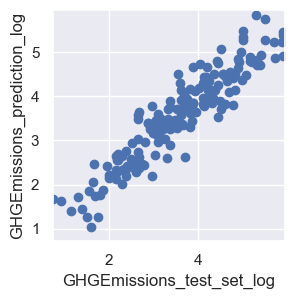

In [36]:
# Comparison between ypred and ytest
plt.figure(figsize=(3, 3))
plt.plot(ytest_select, ypred_select, 'o')
plt.xlabel('GHGEmissions_test_set_log')
plt.xlim([min([ytest_select.min(), ypred_select.min()]),
          max([ytest_select.max(), ypred_select.max()])])
plt.ylabel('GHGEmissions_prediction_log')
plt.ylim([min([ytest_select.min(), ypred_select.min()]),
          max([ytest_select.max(), ypred_select.max()])])
plt.show()

Comparing this scatter plot with the previous one, the predicted values of GHGEmissions is more accurate when using ENERGYSTARScore.

##### <font id='Sec.2.3.3.2'> ii) Features importance

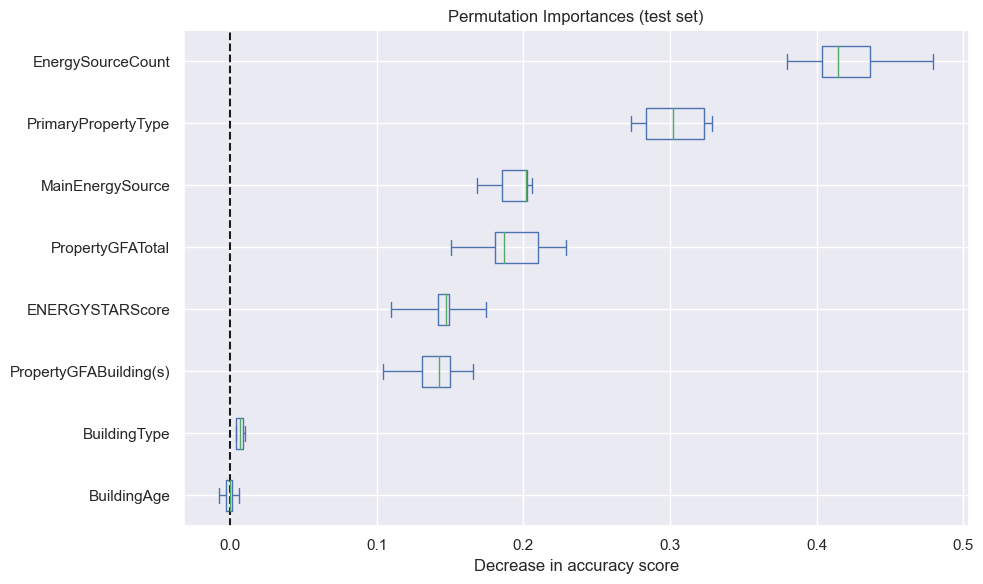

In [37]:
# Fit the model
estimator.fit(xtrain_select, ytrain_select)
# Perform permutation importance
result = permutation_importance(estimator, xtest, ytest,
                                n_repeats=5, random_state=42, n_jobs=-1)

# Get importance
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                           columns=xtrain_select.columns[sorted_importances_idx])

ax = importances.plot.box(vert=False, whis=10, figsize=(10, 6))
ax.set_title('Permutation Importances (test set)')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()

We see that ENERGYSTARScore occupy the 5th position in terms of Importance.

### <font id='Sec.2.4'> D. Summary

- Best model in terms of highest r2 score is **KernelRidge** for the prediction of **GHGEmissions**.
- The final list of column is: **PropertyGFATotal, PropertyGFABuilding(s), PrimaryPropertyType, EnergySourceCount, MainEnergySource, BuildingType, and BuildingAge**.
- **ENERGYSTARSCore gave better score** for the prediction. It can be **added to the final list of columns**.